# Goals

Humor has been an essential part of human interaction for centuries. However, it can be difficult to quantify and to qualify what makes something funny. Knowing what people tend to view more funny or less can help understand what makes a good joke.

The goal of this project is to use unsupervised learning techniques to try to see if we can cluster jokes based on their ratings and if those clusters can help us to identify any patterns or trends in the way people tend to rate jokes. This will require us to use clustering algorithms to group similar jokes together and then to analyze those clusters in order to find if they contain any meaningful information about the jokes-ratings relationship.

# Imports

In [27]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import textwrap
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
import wordcloud


nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/emigoi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/emigoi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
import warnings
warnings.filterwarnings("ignore")

# Data

The data for this project is from [Jester Datasets](https://eigentaste.berkeley.edu/dataset/) (Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001).

There are several versions of the dataset available. They differ in the number of raters, number of jokes and dates when they were collected. In this project, they will be combined and analyzed together.

The datasets themselves contain a list of jokes and a matrix of ratings. The list of jokes are the jokes which were rated. Their indices correspond with columns in the matrix. Each row in the matrix represents ratings of one rater. The first column is the number of rated jokes and the rest are ratings from -10.0 to 10.0 and 99.0 representing "not rated".

Below are descriptions of each part of the dataset:

- Dataset 1 - 100 jokes and ratings from 73,421 users: collected between April 1999 - May 2003
  - [Ratings Part 1](https://eigentaste.berkeley.edu/dataset/jester_dataset_1_1.zip) - data from 24,983 users who have rated 36 or more jokes, a matrix with dimensions 24983 X 101
  - [Ratings Part 2](https://eigentaste.berkeley.edu/dataset/jester_dataset_1_2.zip) - data from 23,500 users who have rated 36 or more jokes, a matrix with dimensions 23500 X 101
  - [Ratings Part 3](https://eigentaste.berkeley.edu/dataset/jester_dataset_1_3.zip) -  data from 24,938 users who have rated between 15 and 35 jokes, a matrix with dimensions 24,938 X 101
  - [Jokes](https://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip) - the text for each of the 100 Dataset 1 jokes
- Dataset 3 - 150 jokes and ratings from 54,905 users: collected between  November 2006 - March 2015 (updated version of the old Dataset 2)
  - [Ratings](https://eigentaste.berkeley.edu/dataset/JesterDataset3.zip) - a matrix with dimensions 54,905 x 151
  - [Jokes](https://eigentaste.berkeley.edu/dataset/Dataset3JokeSet.zip) - the text for each of the 150 Dataset 3 jokes
- Dataset 4 - 158 jokes and ratings from 7,699 users: collected between April 2015 - November 2019
  - [Ratings](https://eigentaste.berkeley.edu/dataset/JesterDataset4.zip) - a matrix with dimensions 7,699 x 159
  - [Jokes](https://eigentaste.berkeley.edu/dataset/Dataset4JokeSet.zip) - the text for each of the 158 Dataset 4 jokes



Overall, the whole dataset spans over 136,025 users rating 158 jokes and collected between April 1999 - November 2019

## Data Loading

### Funciton Definitions

In [29]:
# Jokes in the Dataset 1 are stored as HTML files.
# They need to be extracted from it (jokes are indicated by 2 tags).
# IDs can be determined by filenames.

BEGIN_JOKE_TAG = "<!--begin of joke -->"
END_JOKE_TAG = "<!--end of joke -->"

def parse_joke(joke_filepath: Path):
    with joke_filepath.open() as joke_file:
        joke = joke_file.read()
    joke_begin = joke.find(BEGIN_JOKE_TAG) + len(BEGIN_JOKE_TAG)
    joke_end = joke.find(END_JOKE_TAG)
    id = int(joke_filepath.stem[4:])
    return id, joke[joke_begin:joke_end].strip()

def parse_all_jokes():
    for joke_filepath in JOKES_DIRPATH.iterdir():
        if joke_filepath.name == ".DS_Store":
            continue
        yield parse_joke(joke_filepath)

def read_ratings(filepath: Path):
    """
    Reads the ratings from the excel file. Since the first row is not the header,
    the header is added manually by specifying the first column as `number_of_jokes`
    and other columns are consecutive numbers starting from 1.
    """
    ratings = pd.read_excel(filepath, header=None)
    ratings.columns = ['number_of_jokes'] + list(range(1, ratings.shape[1]))
    return ratings

def compare_jokes(idx):
    print(f"Joke {idx}.")
    if idx >= len(dataset1_jokes):
        print("The joke is not in dataset1")
    else:
        print(dataset1_jokes[idx + 1])
    print("---------")
    if idx >= len(dataset3_jokes):
        print("The joke is not in dataset3")
    else:
        print(dataset3_jokes[idx])
    print("---------")
    if idx >= len(dataset4_jokes):
        print("The joke is not in dataset4")
    else:
        print(dataset4_jokes[idx])
    print()

def add_rating_columns(df1, df2):
    """
    Adds missing ratings for new jokes.
    """
    count1 = df1.shape[1]
    for col in df2.columns[count1:]:
        df1.loc[:, col] = 99.0
    return df1

###

First, we need to download, decompress and load the data.

In [30]:
# Path Constants

ROOT_DIR = Path(".").resolve()
DATA_DIR = ROOT_DIR / "data"
JOKES_DIRPATH = DATA_DIR / "jokes"
DATASET3_JOKESET_FILEPATH = DATA_DIR / "Dataset3JokeSet.xlsx"
DATASET3_RATINGS_FILEPATH = DATA_DIR / "FINAL jester 2006-15.xls"
DATASET4_JOKESET_FILEPATH = DATA_DIR / "Dataset4JokeSet.xlsx"
DATASET4_RATINGS_FILEPATH = DATA_DIR / "[final] April 2015 to Nov 30 2019 - Transformed Jester Data - .xlsx"
DATASET1_1_RATINGS_FILEPATH = DATA_DIR / "jester-data-1.xls"
DATASET1_2_RATINGS_FILEPATH = DATA_DIR / "jester-data-2.xls"
DATASET1_3_RATINGS_FILEPATH = DATA_DIR / "jester-data-3.xls"

In [31]:
%%capture
# Downloading

!wget -nc https://eigentaste.berkeley.edu/dataset/JesterDataset4.zip -P ./data
!wget -nc https://eigentaste.berkeley.edu/dataset/Dataset4JokeSet.zip -P ./data
!wget -nc https://eigentaste.berkeley.edu/dataset/JesterDataset3.zip -P ./data
!wget -nc https://eigentaste.berkeley.edu/dataset/Dataset3JokeSet.zip -P ./data
!wget -nc https://eigentaste.berkeley.edu/dataset/jester_dataset_1_3.zip -P ./data
!wget -nc https://eigentaste.berkeley.edu/dataset/jester_dataset_1_2.zip -P ./data
!wget -nc https://eigentaste.berkeley.edu/dataset/jester_dataset_1_1.zip  -P ./data
!wget -nc https://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip  -P ./data

In [32]:
%%capture
# Decompression

!unzip -n data/JesterDataset4.zip -d ./data
!unzip -n data/Dataset4JokeSet.zip -d ./data
!unzip -n data/JesterDataset3.zip -d ./data
!unzip -n data/Dataset3JokeSet.zip -d ./data
!unzip -n data/jester_dataset_1_3.zip -d ./data
!unzip -n data/jester_dataset_1_2.zip -d ./data
!unzip -n data/jester_dataset_1_1.zip -d ./data
!unzip -n data/jester_dataset_1_joke_texts.zip -d ./data

In [33]:
# Loading

dataset3_jokes = pd.read_excel(DATASET3_JOKESET_FILEPATH)
dataset3_jokes = [dataset3_jokes.columns[0], *[j[0] for j in dataset3_jokes.values]]
dataset3_ratings = read_ratings(DATASET3_RATINGS_FILEPATH)
dataset4_ratings = read_ratings(DATASET4_RATINGS_FILEPATH)
dataset4_jokes = pd.read_excel(DATASET4_JOKESET_FILEPATH)
dataset4_jokes = [dataset4_jokes.columns[0], *[j[0] for j in dataset4_jokes.values]]
dataset1_1_ratings = read_ratings(DATASET1_1_RATINGS_FILEPATH)
dataset1_2_ratings = read_ratings(DATASET1_2_RATINGS_FILEPATH)
dataset1_3_ratings = read_ratings(DATASET1_3_RATINGS_FILEPATH)
dataset1_jokes = dict(parse_all_jokes())

Now, that we have the data, we need to check if the jokes' ids are consistent between the datasets. We are going to do that by sampling 9 jokes and seeing if they are the same in all datasets.

In [34]:
examples = [0, 24, 99, 100, 123, 149, 150, 157, 158]
for idx in examples:
    compare_jokes(idx)

Joke 0.
A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease". <P>
The man replies "Well,thank God I don't have cancer!"
---------
A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease".  The man replies "Well,thank God I don't have cancer!"
---------
A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease".  The man replies "Well,thank God I don't have cancer!"

Joke 24.
Two kindergarten girls were talking outside: one said, "You
won't believe what I saw on the patio yesterday--a condom!"
<P>
The second girl asked, "What's a patio?"
---------
Two kindergarten girls were talking outside: one said, "You won't believe what I saw on the patio yesterday--a condom!"  The second girl asked, "What's a patio?"
---------
Two kindergarten girls were talking outside: one said, "You won't believe what I saw on the patio yesterday--a condom!"  Th

From this test it seems that the jokes' ids are consistent between the datasets. We can now use only the fullest dataset, which is Dataset 4.

In [35]:
jokes = dataset4_jokes.copy()
dataset1_jokes, dataset3_jokes, dataset4_jokes = None, None, None

According to the dataset description, ratings from different datasets do not overlap (they are collected at different times). We can now combine all the ratings into one dataframe.

In [36]:
ratings = pd.concat([
    add_rating_columns(dataset1_1_ratings, dataset4_ratings),
    add_rating_columns(dataset1_2_ratings, dataset4_ratings),
    add_rating_columns(dataset1_3_ratings, dataset4_ratings),
    add_rating_columns(dataset3_ratings, dataset4_ratings),
    dataset4_ratings
]).reset_index().drop(columns=["index", "number_of_jokes"])

# Ratings is a dataframe with columns corresponding to jokes and rows corresponding to users.
# The values are ratings from -10.0 to 10.0. 99.0 indicates that the user did not rate the joke.

ratings

,1,2,3,4,5,6,7,8,9,10,...,149,150,151,152,153,154,155,156,157,158
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136020,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,...,0.00,99.00,0.00,0.00,0.00,99.0,0.00,0.00,0.00,99.00
136021,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
136022,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,...,99.00,8.63,99.00,6.76,0.00,3.5,6.26,99.00,-2.66,0.65
136023,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,...,2.03,99.00,2.05,2.05,0.73,0.0,2.97,0.57,0.00,0.00


The resulting ratings dataframe has 136,025 rows and 158 columns corresponding to the number of reviewers and jokes.

# EDA

#### Function Definitions

In [37]:
def show_hist_ratings_per_joke(df, kde=True, bins=20):
    df = df[df != 99.0]
    df = df.count(axis=0)
    plt.title("Distributions of the number of reviews per joke")
    sns.histplot(df, kde=kde, bins=bins)
    plt.show()

def show_hist_ratings_per_user(df, kde=True, bins=20):
    plt.title("Number of jokes rated per user")
    sns.histplot(df[df != 99].count(axis=1), kde=kde, bins=bins)
    plt.show()

def show_hist_avg_ratings_per_joke(df, kde=True, bins=20):
    df = df[df != 99.0]
    df = df.mean(axis=0)
    mean, std = df.mean(), df.std()
    plt.title(f"Ratings per joke: mean={mean:.2f}, std={std:.2f}")	
    sns.histplot(df, kde=kde, bins=bins)
    plt.show()

def show_hist_avg_ratings_per_user(df, kde=True, bins=20):
    df = df[df != 99.0]
    df = df.mean(axis=1)
    mean, std = df.mean(), df.std()
    plt.title(f"Ratings per user: mean={mean:.2f}, std={std:.2f}")
    sns.histplot(df, kde=kde, bins=bins)
    plt.show()

##

With the data loaded, we can now explore it. First, we will look that ratings have correct values and the number of missing and nonmissing values.

In [38]:
print("Nonmissing ratings smaller than -10:", (ratings[ratings != 99.0] < -10.0).sum().sum())
print("Nonmissing ratings larger than 10:", (ratings[ratings != 99.0] > 10.0).sum().sum())
missing = (ratings == 99.0).sum().sum()
nonmissing = (ratings != 99.0).sum().sum()
print("Ratings equal to 99 (missing):", missing)	
print("Nonmissing ratings:", nonmissing)
print("Proportion of missing ratings:", missing / (missing + nonmissing))

Nonmissing ratings smaller than -10: 262
Nonmissing ratings larger than 10: 279
Ratings equal to 99 (missing): 15406703
Nonmissing ratings: 6085247
Proportion of missing ratings: 0.7168592426466653


As we can see there are some incorrect ratings (not between -10 and 10). We'll deal with them by clipping them to the correct range.

The other thing we can see is that there are ~72% of missing values. While the number is high, it is not too high for such types of datasets. We can probably get good results just by imputing the missing values to the global mean.

In [39]:
# Clip non-missing ratings to [-10, 10] range.
ratings[ratings != 99.0] = ratings[ratings != 99.0].clip(-10.0, 10.0)

In [40]:
print("Nonmissing ratings smaller than -10:", (ratings[ratings != 99.0] < -10.0).sum().sum())
print("Nonmissing ratings larger than 10:", (ratings[ratings != 99.0] > 10.0).sum().sum())
missing = (ratings == 99.0).sum().sum()
nonmissing = (ratings != 99.0).sum().sum()
print("Ratings equal to 99 (missing):", missing)	
print("Nonmissing ratings:", nonmissing)
print("Proportion of missing ratings:", missing / (missing + nonmissing))

Nonmissing ratings smaller than -10: 0
Nonmissing ratings larger than 10: 0
Ratings equal to 99 (missing): 15406703
Nonmissing ratings: 6085247
Proportion of missing ratings: 0.7168592426466653


Now, let's take a look at different distribution of ratings, number of jokes rated and number of raters. This should allow us to see if there are any outliers or other interesting patterns.

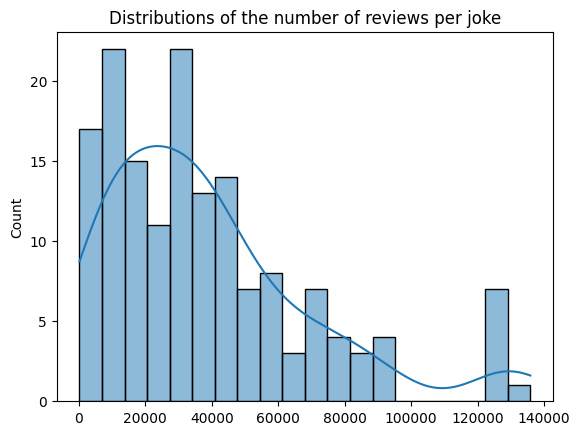

In [41]:
show_hist_ratings_per_joke(ratings)

The number of reviews per joke shows that there are not any obvious problems. The majority of jokes is concentrated around 30000 reviews. There is also a smaller group with around 70000 reviews. There is also about 8 jokes with more than 120000 reviews. We will probably have to leave them in since it's a pretty sizeable group for our dataset and it will affect a lot of reviewers.

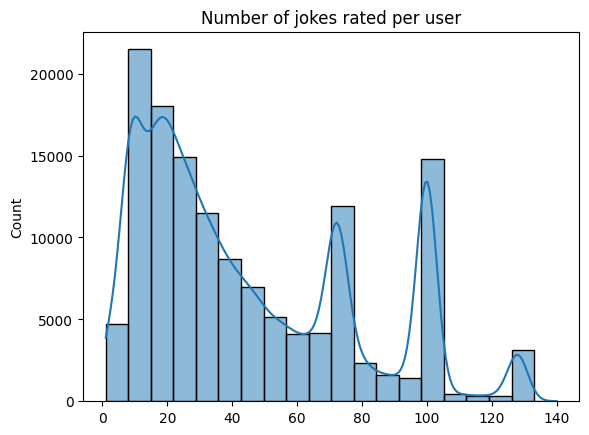

In [42]:
show_hist_ratings_per_user(ratings)

The number of reviews made by users seems to be following something similar to a log-normal distribution, which is to be expected with volunteer ratings of a large number of items. There are three spikes in the distribution, which probably correspond to the three datasets and some limit on the number of jokes reviewed per user.

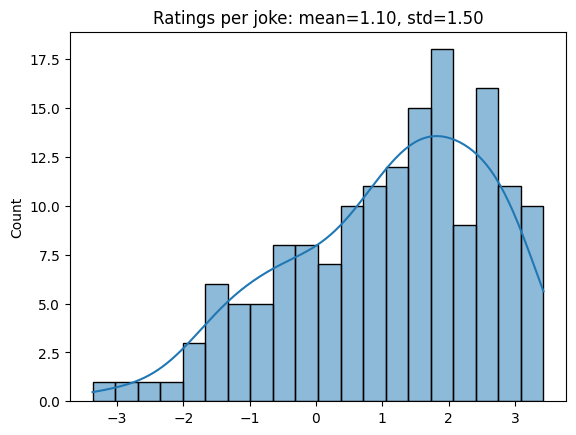

In [43]:
show_hist_avg_ratings_per_joke(ratings)

As can be seen, the dataset doesn't contain any jokes that are overwhelmingly considered to be great or awful (means are between -3.5 and 3.5). Interestingly, the average joke ratings are heavily skewed to be positive. Otherwise the distribution does not show any problems.

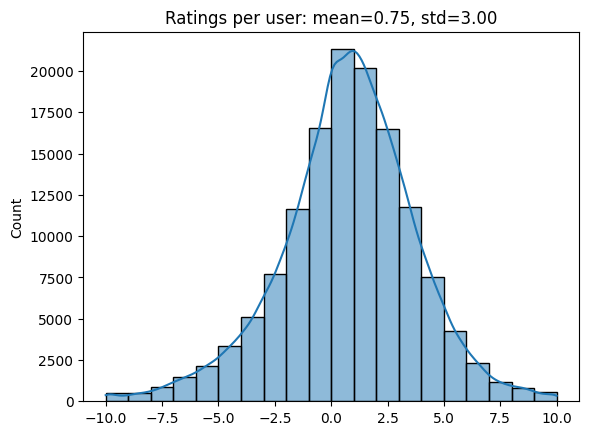

In [44]:
show_hist_avg_ratings_per_user(ratings)

The distribution of average ratings per user is normal and also skewed to the positive side. Compared to average joke ratings, the average user ratings are more spread out and there are some reviewers who rated most jokes either very positively or very negatively (a lot of jokes are rated either +10 or -10).

Now, that we have a general idea of the data, we can start removing the outliers. First, we will remove the jokes with a low number of ratings. For that let's look at the number of jokes that have lower number of ratings than a list of thresholds.

In [45]:
counts = ratings[ratings != 99].count(axis=0)
total = counts.shape[0]
for k in (1000, 1300, 1350, 1500, 4000, 5000, 6000, 8000, 10000, 20000, 50000, 100000, ratings.shape[0]):
    number_less_k = (counts < k).sum()
    print(f"{number_less_k} ({number_less_k/total*100:.1f}%) jokes have fewer than {k} ratings.")

1 (0.6%) jokes have fewer than 1000 ratings.
2 (1.3%) jokes have fewer than 1300 ratings.
7 (4.4%) jokes have fewer than 1350 ratings.
9 (5.7%) jokes have fewer than 1500 ratings.
9 (5.7%) jokes have fewer than 4000 ratings.
11 (7.0%) jokes have fewer than 5000 ratings.
14 (8.9%) jokes have fewer than 6000 ratings.
19 (12.0%) jokes have fewer than 8000 ratings.
24 (15.2%) jokes have fewer than 10000 ratings.
53 (33.5%) jokes have fewer than 20000 ratings.
116 (73.4%) jokes have fewer than 50000 ratings.
150 (94.9%) jokes have fewer than 100000 ratings.
158 (100.0%) jokes have fewer than 136025 ratings.


As we can see there is a number of jokes with fewer than 1500 ratings, while all the other have more than 4000. Since they only make up about 5% of the jokes, we can remove them.

In [46]:
counts[counts < 1500].index

Index([116, 151, 152, 153, 154, 155, 156, 157, 158], dtype='object')

These jokes are mostly from the newest dataset. There is also one joke from the older dataset. In order to remain consistent with indices, we will need to track the indices of the remaining jokes.

In [47]:
idx_to_joke_id = {i: i for i in range(116)}
for i in range(116, 150):
    idx_to_joke_id[i] = i + 1
idx_to_joke_id[0], idx_to_joke_id[115], idx_to_joke_id[116], idx_to_joke_id[149]

(0, 115, 117, 150)

In [48]:
raw_ratings = ratings.copy()
counts = raw_ratings[raw_ratings != 99].count(axis=0)
print(raw_ratings.shape)
raw_ratings = raw_ratings.drop(columns=[col for col in raw_ratings.columns if (counts[col] < 1500)])
raw_ratings.shape

(136025, 158)


(136025, 149)

Now, we will do the same for the reviwers with a low number of rated jokes.

In [49]:
counts = raw_ratings[raw_ratings != 99].count(axis=1)
total = raw_ratings.shape[0]
for k in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100, raw_ratings.shape[1]):
    number_less_k = (counts < k).sum()
    print(f"{number_less_k} ({number_less_k/total*100:.1f}%) reviewers have reviewed fewer than {k} jokes.")

13 (0.0%) reviewers have reviewed fewer than 1 jokes.
1224 (0.9%) reviewers have reviewed fewer than 2 jokes.
2250 (1.7%) reviewers have reviewed fewer than 3 jokes.
2988 (2.2%) reviewers have reviewed fewer than 4 jokes.
3599 (2.6%) reviewers have reviewed fewer than 5 jokes.
4057 (3.0%) reviewers have reviewed fewer than 6 jokes.
4392 (3.2%) reviewers have reviewed fewer than 7 jokes.
4704 (3.5%) reviewers have reviewed fewer than 8 jokes.
13250 (9.7%) reviewers have reviewed fewer than 9 jokes.
15955 (11.7%) reviewers have reviewed fewer than 10 jokes.
26407 (19.4%) reviewers have reviewed fewer than 15 jokes.
39413 (29.0%) reviewers have reviewed fewer than 20 jokes.
86428 (63.5%) reviewers have reviewed fewer than 50 jokes.
117327 (86.3%) reviewers have reviewed fewer than 100 jokes.
136025 (100.0%) reviewers have reviewed fewer than 149 jokes.


Here, a good threshold seems to be 6 jokes, since we do not want to remove too many reviewers and affect the number of reviews per joke.

In [50]:
ratings_proc = raw_ratings[counts >= 6]
ratings_proc[ratings_proc != 99].count(axis=1).min(), ratings_proc[ratings_proc != 99].count(axis=0).min()

(6, 4435)

With these outliers removed, we can now look at the distribution of ratings again and check if everything is still fine.

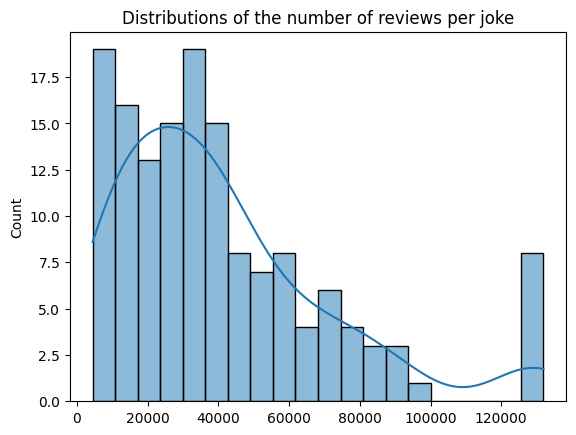

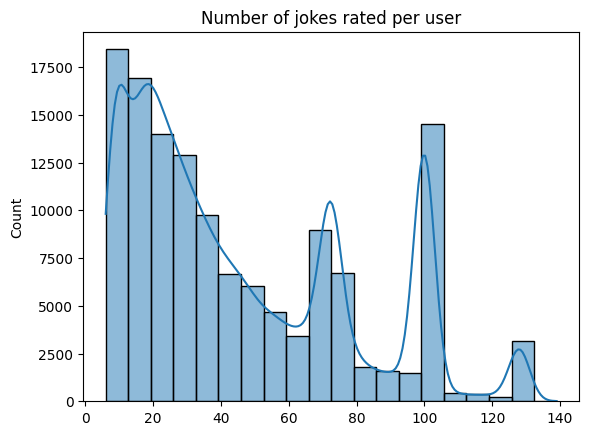

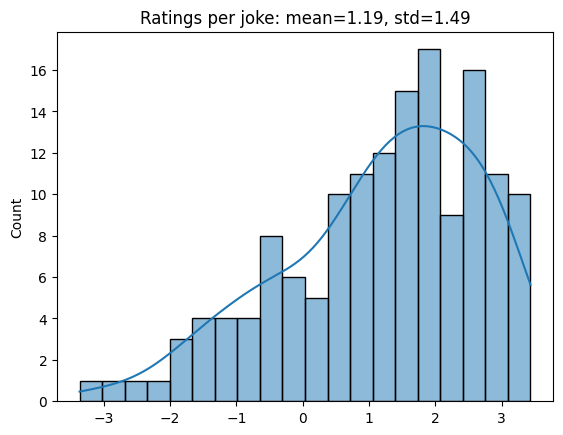

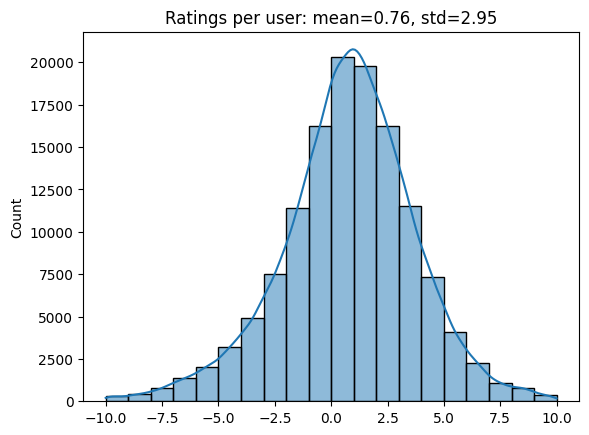

In [51]:
show_hist_ratings_per_joke(ratings_proc)
show_hist_ratings_per_user(ratings_proc)
show_hist_avg_ratings_per_joke(ratings_proc)
show_hist_avg_ratings_per_user(ratings_proc)

The histogram show that the distribution are still ok. There are a few minor changes in means, but, overall, the distributions are still pretty similar and the major outliers are gone.

The final thing to do is to impute the missing values. We will do that by replacing them with the global mean. The other thing we will do is to map all the ratings to the range from -1 to 1. This is done since these mapping are still similar, but it should make the methods used a bit more stable due to reduced variance.

In [52]:
mean_joke_rating = 1.19
ratings_for_model = ratings_proc[ratings_proc != 99] / 10.0 # changing range from [-10, 10] to [-1, 1]

# Modeling

#### Function Definitions

In [53]:
def calculate_scores(ratings, labels, inertia):
    ratings = ratings.T
    sil = metrics.silhouette_score(ratings, labels, metric="euclidean") # The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
    cal_har = metrics.calinski_harabasz_score(ratings, labels) # The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster
    dav_bou = metrics.davies_bouldin_score(ratings, labels) # Zero is the lowest possible score. Values closer to zero indicate a better partition.
    distortion = inertia / ratings.shape[0]
    return sil, cal_har, dav_bou, distortion


def print_metrics(sil, cal_har, dav_bou, distortion):
    print(f"Silhouette Score = {sil:.3f}")
    print(f"Calinski-Harabasz Score = {cal_har:.3f}")
    print(f"Davies-Bouldin Score = {dav_bou:.3f}")
    print(f"Distortion = {distortion:.3f}")


def calculate_cluster_score(ratings, min_cluster=2, max_cluster=9, verbose=True):
    results_data = []
    for n_clusters in range(min_cluster, max_cluster):
        labels, cluster_centers, inertia = kmeans_cluster_jokes(ratings, n_clusters)
        sil, cal_har, dav_bou, distortion = calculate_scores(ratings, labels, inertia)
        results_data.append((n_clusters, sil, cal_har, dav_bou, distortion))
        if verbose:
            print(f"{n_clusters} clusters")
            print_metrics(sil, cal_har, dav_bou, distortion)
            plt.title(f"Number of jokes per cluster (#clusters={n_clusters})")
            sns.histplot(labels, kde=False, bins=n_clusters)
            plt.show()
    results = pd.DataFrame(
        results_data,
        columns=["n_clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "Distortion"]
    )
    return results

def kmeans_cluster_jokes(df, n_clusters=10, random_state=0):
    """
    Clusters jokes based on the ratings.
    """
    df = df.T
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto").fit(df)
    return kmeans.labels_, kmeans.cluster_centers_, kmeans.inertia_

def plot_kmeans_elbow(results, drop_cols=None):
    if "Silhouette" not in drop_cols:
        plt.plot(results["n_clusters"], results["Silhouette"], label="Silhouette")
    if "Calinski-Harabasz" not in drop_cols:
        plt.plot(results["n_clusters"], results["Calinski-Harabasz"], label="Calinski-Harabasz")
    if "Davies-Bouldin" not in drop_cols:
        plt.plot(results["n_clusters"], results["Davies-Bouldin"], label="Davies-Bouldin")
    plt.legend()
    plt.title("Elbow Curves")
    plt.xlabel("Number of clusters")
    plt.ylabel("Score")
    plt.show()

def split_jokes_by_cluster(labels, jokes):
    clusters = [[] for _ in range(len(set(labels)))]
    for i, label in enumerate(labels):
        clusters[label].append(jokes[idx_to_joke_id[i]])
    return clusters

def sample_cluster_jokes(cluster):
    for cluster_idx, cluster_jokes in enumerate(cluster):
        print(f"\nCluster {cluster_idx} jokes")
        for idx in range(0, len(cluster_jokes), max(len(cluster_jokes) // 2 - 1, 1)):
            print(textwrap.fill(cluster_jokes[idx], 80))
            print("______________")

def plot_hist_of_ratings_per_cluster(labels, ratings):
    """
    Creates an overlayed historgam of distribution of ratings per cluster.

    Args:
        labels: A list of cluster labels for each joke.
        ratings: A dataframe of ratings.
    """
    df_dict = {"rating": [], "cluster": []}
    for idx, label in enumerate(labels):
        joke_ratings = ratings.iloc[:, idx]
        joke_ratings = joke_ratings[joke_ratings != 99.0]
        label = f"Cluster {label}"
        for rating in joke_ratings:
            if rating > 10 or rating < -10:
                print(idx, label, rating)
                continue
            df_dict["rating"].append(rating)
            df_dict["cluster"].append(label)
    df = pd.DataFrame(df_dict).sort_values("cluster", ascending=True)
    distribution = df.groupby("cluster").agg({"rating": ["mean", "std"]})
    for idx, i in enumerate(distribution.iterrows()):
        print(f"Cluster {idx}: mean={i[1].rating['mean']:.2f}, std={i[1].rating['std']:.2f}, count={(labels == idx).sum()}")
    sns.catplot(data=df, x="cluster", y="rating", kind="boxen")
    plt.show()

####

With the data cleaned, we can now start modeling.

## Evaluation

[Metric Explanations from scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

First of all, we need to determine how resulting clusters are going to be evaluated. Since we cannot do it by hand for all configurations, we will use some of the metrics that are suitable for cluster evaluation. These metrics are:

- Davies-Bouldin Index - a measure of how well separated the clusters are. The lower the better. The index signifies the 'average similarity' between clusters.
- Calinski-Harabasz Index - a measure of how well defined the clusters are. The higher the better. The index is based on the ratio between the between-cluster dispersion and the within-cluster dispersion.
- Silhouette Coefficient - a measure of how well defined the clusters are. The higher the better. The coefficient is based on the mean distance between a sample and all other points in the same class and the mean distance between a sample and all other points in the next nearest cluster.

## Clustering

Now, we are going to try different methods to generate clusters. We will be using k-means for clustering and 3 different feature preprocessing methods:

- Using raw ratings
- Using PCA to reduce the dimensionality of the data
- Using NMF to reduce the dimensionality of the data

For each of the methods, we will try different number of clusters and see which one gives the best results. For that, we will use the evaluation metrics mentioned above. We will also use the elbow method to determine the optimal number of clusters for dimensionality reduction methods.

After that we will try to see what are the clusters for the best configuration.

### Baseline

The first method is to use the raw ratings as features.

In [54]:
# We need to fill in the missing values with the mean rating for each joke normalized to the range [-1, 1]
ratings_for_model_mean_fill = ratings_for_model.fillna(mean_joke_rating / 10.0)

In [174]:
kmeans_results = calculate_cluster_score(ratings_for_model_mean_fill, verbose=False)
kmeans_results

,n_clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin,Distortion
0,2,0.109652,1.344255,0.801082,9908.086683
1,3,0.121494,6.749413,2.312605,9152.475114
2,4,0.005343,4.910022,2.446886,9076.627751
3,5,0.027543,6.227994,2.454463,8524.035452
4,6,0.003960,4.636127,2.524391,8603.968545
5,7,-0.000515,4.026155,2.505379,8545.019796
6,8,0.002352,4.966702,1.613078,8020.938507


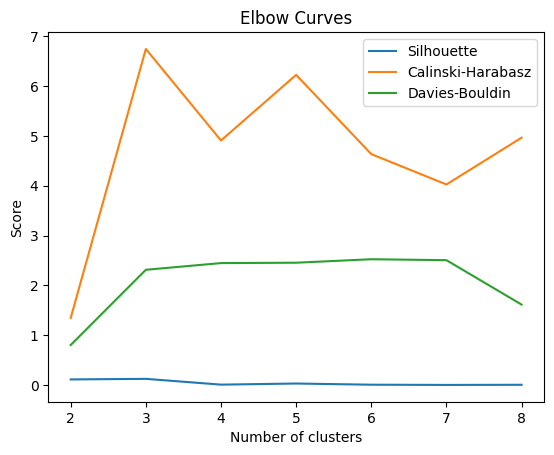

In [36]:
plot_kmeans_elbow(kmeans_results)

From the data and the visualization, we can see that the best number of clusters seems to be either 2 or 3. This coincides with the best value of Silhouette Coefficient and Callinski-Harabasz Index. For the Davies-Bouldin Index, it is not the best, but the improvent jump is really large for 3 clusters.

Now, we are going to sample a few jokes from each cluster and see if they are some obvious patterns within the clusters. Also, we are going to see the distribution of ratings for each cluster.

In [99]:
kmeans_labels, _, _ = kmeans_cluster_jokes(ratings_for_model_mean_fill, 3)
kmeans_jokes = split_jokes_by_cluster(kmeans_labels, jokes)

In [32]:
sample_cluster_jokes(kmeans_jokes)


Cluster 0 jokes
The graduate with a Science degree asks, "Why does it work?" The graduate with
an Engineering degree asks, "How does it work?" The graduate with an Accounting
degree Asks, "How much will it cost?"  The graduate with a  Liberal Arts degree
asks, "Do you want fries  with  that?"
______________

Cluster 1 jokes
Bill & Hillary are on a trip back to Arkansas. They're almost out of gas, so
Bill pulls into a service station on the outskirts of town. The attendant runs
out of the station to serve them when Hillary realizes it's an old boyfriend
from high school. She and the attendant chat as he gases up their car and cleans
the windows. Then they all say good-bye.   As Bill pulls the car onto the road,
he turns to Hillary and says, 'Now aren't you glad you married me and not him ?
You could've been the wife of a grease monkey !'   To which Hillary replied,
'No, Bill. If I would have married him, you'd be pumping gas and he would be the
President !'
______________
A Panda bear 

Cluster 0: mean=1.94, std=4.99, count=1
Cluster 1: mean=1.96, std=5.04, count=115
Cluster 2: mean=-0.81, std=5.34, count=33


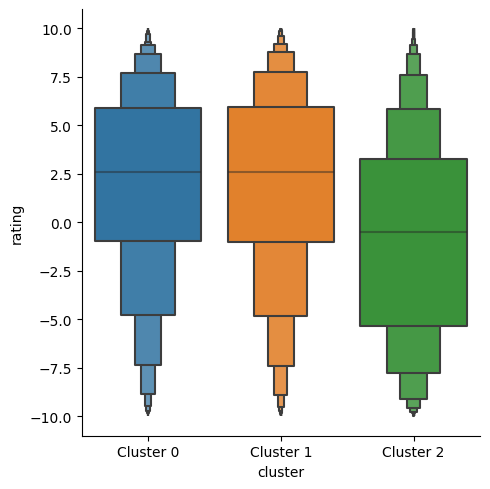

In [53]:
plot_hist_of_ratings_per_cluster(kmeans_labels, ratings_proc)

The most important thing to note is that Cluster 0 has only one joke. This shows that clustering with raw ratings didn't perform too well. In any case, we can look at the other two clusters. (Reclustering with 2 clusters also resulted in one cluster with only one joke, which is very interesting and releaving at how k-means works.)

From them we can see that Cluster 1 seems to contain jokes that are considered to be good, while Cluster 2 contains jokes that are considered to be bad. Another pattern is that Cluster 1 seems to contain longer jokes, while Cluster 2 contains shorter jokes.

This might mean either that longer jokes (at least for this dataset) are usually better for some reason. This reason might be is that good jokes usually have a longer setup allowing for a better punchline. Another reason might be that longer jokes are more difficult to write and therefore are more likely to be good.

### Preprocessing with PCA

#### Function Definitions

In [55]:
def plot_pca_explained_variance(explained_variance_ratio):
    explained_variance = pca.explained_variance_ratio_.cumsum()
    points = []
    for explained in (0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99):
        point = np.argmax(explained_variance > explained)
        points.append((point, explained))
        print(f"{explained:.2f} variance explained by {point} components")
    plt.plot(explained_variance)
    plt.scatter(*zip(*points), color="red")
    plt.show()


def get_pca_ratings(ratings, n_components):
    """
    Performs PCA decomposition on ratings and returns the transformed ratings.
    """
    pca = PCA(n_components=n_components)
    return pca.fit_transform(ratings.T).T

####

In this section, we are going to use PCA to reduce the dimensionality of the data.

#### Calculating the optimal number of components

First, we need to determine the optimal number of components to use. We will use the elbow method over the expained variance to determine this.

0.20 variance explained by 2 components
0.40 variance explained by 10 components
0.60 variance explained by 29 components
0.80 variance explained by 64 components
0.90 variance explained by 91 components
0.95 variance explained by 109 components
0.99 variance explained by 135 components


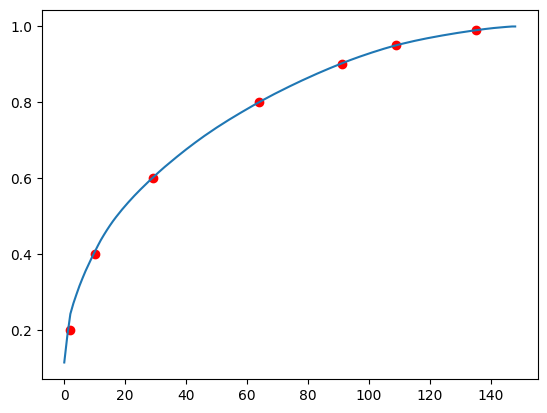

In [55]:
pca = PCA(n_components=149)
pca.fit(ratings_for_model_mean_fill.T)
plot_pca_explained_variance(pca.explained_variance_ratio_)

From this plot, we can see that choosing 64 components will give us good results, since we still keep about 80% of the explained variance and reduce the number of dimensions to about 43%.

#### Results

In [56]:
pca_ratings = get_pca_ratings(ratings_for_model_mean_fill, 0.8)
pca_results = calculate_cluster_score(pca_ratings, verbose=False)

In [58]:
pca_results

,n_clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin,Distortion
0,2,0.288084,12.760316,2.449164,7368.598400
1,3,0.236883,14.926203,2.502107,6648.765303
2,4,0.184386,10.960018,1.853019,6527.955885
3,5,0.184123,8.944467,1.642208,6414.498762
4,6,0.186606,8.202918,1.519143,6223.292895
5,7,0.229873,10.079795,1.643291,5616.235592
6,8,0.233219,9.252765,1.550979,5487.504463


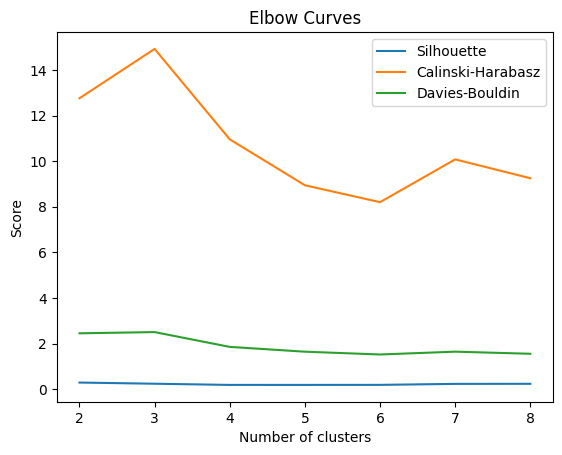

In [59]:
plot_kmeans_elbow(pca_results)

For k-means with PCA preprocessing, the best number of cluster also seems to be 3. It is not too suprising since if there were more obvious clusters, we could expect even k-means with raw ratings to find them albeit with a lot of noise.

Now, let's take a look at these clusters.

In [62]:
pca_kmeans_labels, _, _ = kmeans_cluster_jokes(pca_ratings, 3)
pca_kmeans_jokes = split_jokes_by_cluster(pca_kmeans_labels, jokes)
sample_cluster_jokes(pca_kmeans_jokes)


Cluster 0 jokes
What's the difference between a used tire and 365 used condoms?  One's a
Goodyear, the other's a great year.
______________
There was an engineer who had an exceptional gift for fixing all  things
mechanical.  After serving his company loyally for over 30  years, he happily
retired.  Several years later the company contacted  him regarding a seemingly
impossible problem they were having with  one of their multi-million dollar
machines. They had tried everything and  everyone else to get the machine fixed,
but to no avail.  In  desperation, they called on the retired engineer who had
solved so  many of their problems in the past. The engineer reluctantly took the
challenge.  He spent a day studying  the huge machine.  At the end of the day,
he marked a small "x" in  chalk on a particular component of the machine and
proudly stated,  "This is where your problem is". The part was replaced and the
machine worked perfectly again. The  company received a bill for $50,000 fro

Cluster 0: mean=2.44, std=4.87, count=23
Cluster 1: mean=1.82, std=5.15, count=79
Cluster 2: mean=-0.32, std=5.33, count=47


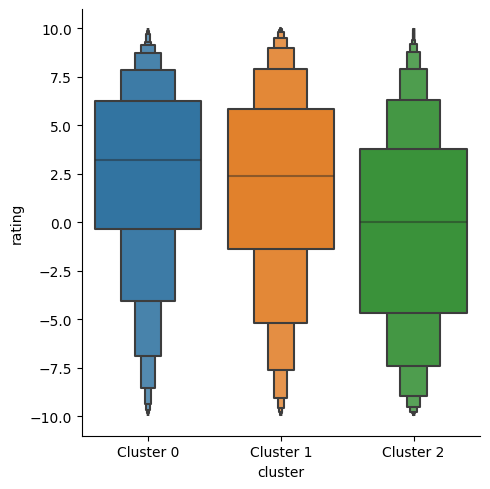

In [63]:
plot_hist_of_ratings_per_cluster(pca_kmeans_labels, ratings_proc)

Here, we can see a similar pattern to the one we saw with raw ratings. Cluster 0 and 1 contain jokes that are on average considered to be good and these jokes are fairly long. Cluster 2 contains worse jokes which are also shorter. The main difference is that there are 2 clusters with good jokes, which have a small difference in the average rating.

There might be a pattern to the difference between these 2 clusters, but that would require further investigation.

### Preprocessing with NMF

#### Function Definitions

In [57]:
def get_nmf_ratings(ratings, n_components):
    """
    Performs NMF decomposition on ratings and returns the transformed ratings.
    """
    nmf = NMF(n_components=n_components)
    return nmf.fit_transform(ratings.T).T


def plot_nmf_explained_variance(ratings, components_to_check=[5, 10, 20, 30, 45, 60, 80, 100]):
    explained_variance = []
    ratings = ratings.T
    for n_components in components_to_check:
        print(n_components)
        nmf = NMF(n_components=n_components)
        nmf.fit(ratings)
        reconstructed = nmf.inverse_transform(nmf.transform(ratings))
        explained_variance.append(
            metrics.explained_variance_score(
                ratings,
                reconstructed
            )
        )

    explained_variance = np.array(explained_variance)
    points = []
    for idx, explained in enumerate(explained_variance):
        point = components_to_check[idx]
        points.append((point, explained))
        print(f"{explained:.2f} variance explained by {point} components")
    plt.plot(*zip(*points))
    plt.scatter(*zip(*points), color="red")
    plt.savefig("nmf_explained_variance.png")
    plt.show()

####

The final method we are going to try is k-means with NMF preprocessing. For this we are going to perform similar steps as with PCA. The main difference is that we need to change the rating to be non-negative. We are going to do that by adding 1 to all ratings and then dividing them by 2 to get the values between 0 and 1.

In [58]:
ratings_for_nmf_mean_fill = (ratings_for_model_mean_fill + 1) / 2
(ratings_for_nmf_mean_fill >= 0).all().all()

True

#### Calculating the optimal number of components

For NMF, we also need to determine the optimal number of components. Since NMF has to recalculate the decomposition every time we change the number of compenents, we are going to use only 1% and 5% of reviewers to estimate the explained variance. We are also going to calculate the explained variance at predefined points.

5
10
20
30
45
60
80
100
0.28 variance explained by 5 components
0.39 variance explained by 10 components
0.56 variance explained by 20 components
0.64 variance explained by 30 components
0.74 variance explained by 45 components
0.80 variance explained by 60 components
0.87 variance explained by 80 components
0.92 variance explained by 100 components


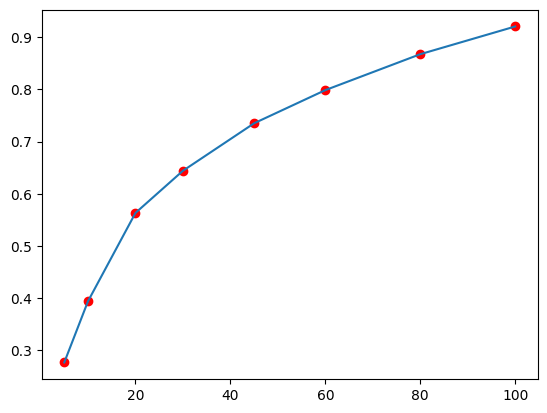

In [34]:
plot_nmf_explained_variance(ratings_for_nmf_mean_fill[::100]) # This took 100 seconds to run

5
10
20
30
45
60
80
100
0.27 variance explained by 5 components
0.39 variance explained by 10 components
0.57 variance explained by 20 components
0.65 variance explained by 30 components
0.74 variance explained by 45 components
0.80 variance explained by 60 components
0.86 variance explained by 80 components
0.92 variance explained by 100 components


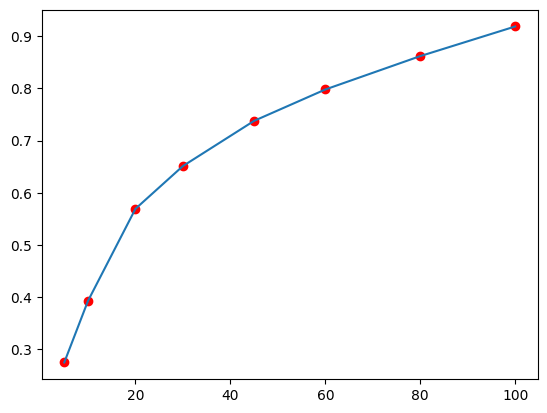

In [35]:
plot_nmf_explained_variance(ratings_for_nmf_mean_fill[::20])  # This took 560 seconds to run

The explained variance plots are similar when using both 1% and 5% of the reviewers. This show that most likely the explained variance will behave similarly for the whole dataset.

Similarly to PCA, we are going to choose the number of components that gives us about 80% of the explained variance. This reduces the number of dimensions to about 60 (~40% of original).

#### Results

In [59]:
nmf_ratings = get_nmf_ratings(ratings_for_nmf_mean_fill, 60)
nmf_results = calculate_cluster_score(nmf_ratings.T, verbose=False)

In [37]:
nmf_results

,n_clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin,Distortion
0,2,0.917948,178.860130,0.362374,0.350841
1,3,0.901814,144.346430,0.041104,0.236243
2,4,0.759170,116.390969,0.090520,0.198026
3,5,0.780687,185.049400,0.070527,0.099097
4,6,0.791194,300.369796,0.058747,0.049728
5,7,0.719680,331.140466,0.072573,0.037227
6,8,0.734240,600.164426,0.062791,0.017517


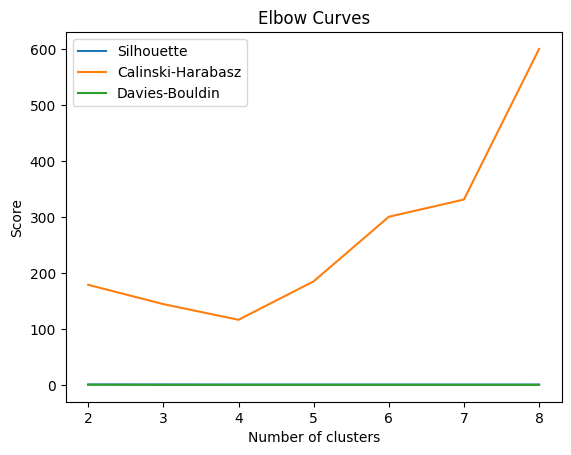

In [38]:
plot_kmeans_elbow(nmf_results)

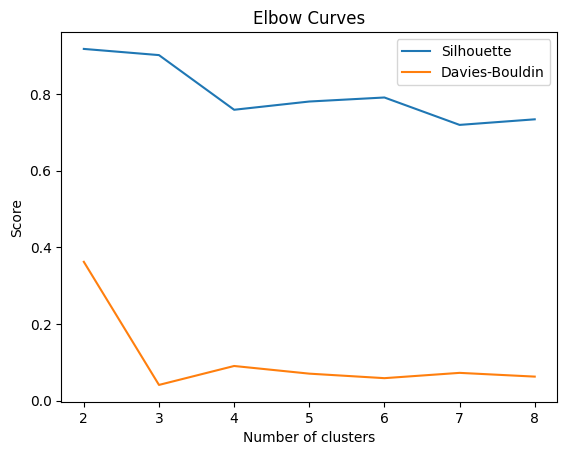

In [40]:
plot_kmeans_elbow(nmf_results, drop_cols=["Calinski-Harabasz"])

Here, we should note two important things. First, Callinski-Harabasz Index is increasing with the increase of the number of clusters and doesn't seem to stop even when reaching a high number of clusters. Second, the other two metrics are achieving their best values around 3 cluters. We need to consider that only Davies-Bouldin Index correlates with how well separated the clusters are, while the other two metrics are more related to how well defined the clusters are. This means that we should probably choose the number of clusters based on Davies-Bouldin Index in this case, if we want to extract meaningful patterns.

In any case, we should explore why metrics behave this way. It might be connected with how spread out the new points are after preprocessing. This can be roughly estimated by looking at the variance of the data after preprocessing. We'll compare the values between PCA and NMF.

In [64]:
print(f"Mean of pca: {pca_ratings.mean().mean():.2f}")
print(f"Mean of nmf: {nmf_ratings.mean().mean():.2f}")
print(f"Std of pca: {pca_ratings.std().mean():.2f}")
print(f"Std of nmf: {nmf_ratings.std().mean():.2f}")

Mean of pca: -0.00
Mean of nmf: 0.02
Std of pca: 11.10
Std of nmf: 0.10


From these values, we can clearly see that while PCA has a large variance, NMF has a variance that is much closer to 0. This means that the data after NMF is much more likelier to be already in a 'blob' together around 0. This can cause the clusters to actually not exist meaning we can't really reach a good separattion between any clusters we might find, while on the other hand allowing to make a lot of clusters that are very 'smooth' and dense.

Since it's hard to tell which number of clusters is going to be the best from just the metrics, we are first going to plot the distribution of ratings for number of clusters 2, 3 and 6.

Cluster 0: mean=1.58, std=5.13, count=37
Cluster 1: mean=2.76, std=4.81, count=14
Cluster 2: mean=3.26, std=4.51, count=1
Cluster 3: mean=0.88, std=5.25, count=33
Cluster 4: mean=0.11, std=5.43, count=21
Cluster 5: mean=1.02, std=5.35, count=43


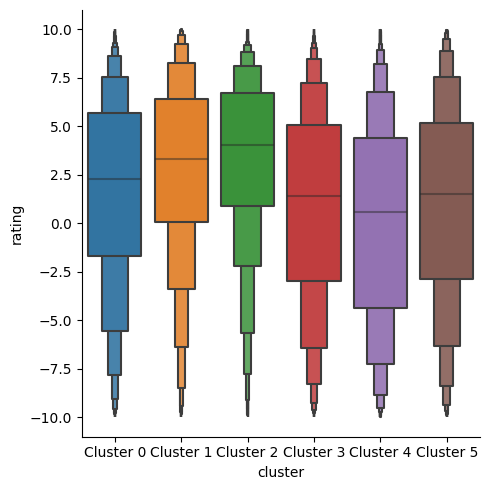

In [82]:
nmf_kmeans_labels_6, _, _ = kmeans_cluster_jokes(nmf_ratings, 6)
plot_hist_of_ratings_per_cluster(nmf_kmeans_labels, ratings_proc)

In [83]:
nmf_kmeans_jokes_6 = split_jokes_by_cluster(nmf_kmeans_labels_6, jokes)
sample_cluster_jokes(nmf_kmeans_jokes_6)


Cluster 0 jokes
A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease".  The man replies "Well,thank God I don't have
cancer!"
______________
A boy comes home from school and tells his mother that he got a part in the
school play.  "What part?" the mother asked. "I play a Jewish husband," the boy
replied.   "Go back to school and tell your teacher that you want a speaking
role!"
______________
An Asian man goes into a New York CityBank to exchange 10,000 yen for American
Currency.  The teller gives him $72.00.  The next month the Asian man goes into
the same bank with 10,000 yen and receives $62.00. He asks, "How come? Only
$62.00?" The teller says "Fluctuations- Fluctuations!"  Whereupon the Asian man
looks back at the teller and says "Fluk you Amelicans too!"
______________

Cluster 1 jokes
This couple had an excellent relationship going until one day he came home from
work to find his girlfriend packing. He asked her why she was l

Cluster 0: mean=0.92, std=5.31, count=76
Cluster 1: mean=1.15, std=5.30, count=72
Cluster 2: mean=3.26, std=4.51, count=1


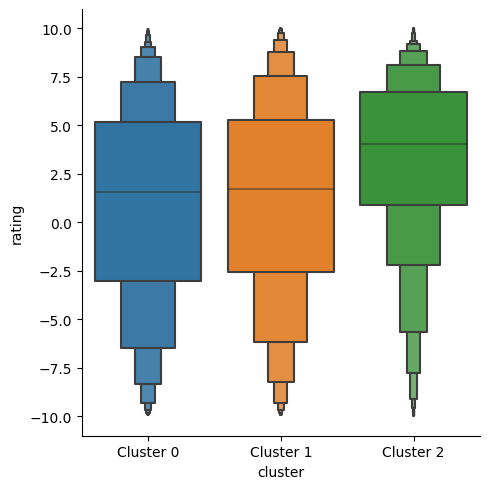

In [77]:
nmf_kmeans_labels, _, _ = kmeans_cluster_jokes(nmf_ratings, 3)
plot_hist_of_ratings_per_cluster(nmf_kmeans_labels, ratings_proc)

Cluster 0: mean=0.97, std=5.31, count=77
Cluster 1: mean=1.15, std=5.30, count=72


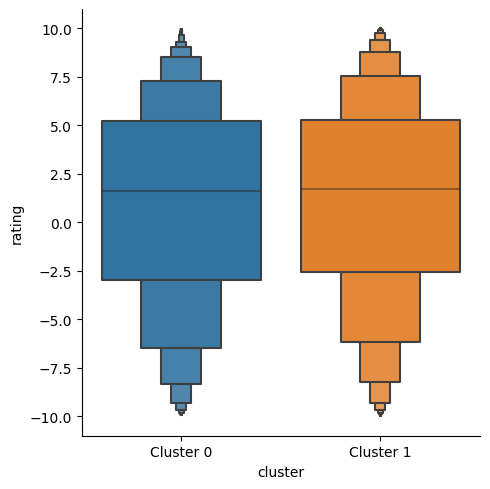

In [85]:
nmf_kmeans_labels_2, _, _ = kmeans_cluster_jokes(nmf_ratings, 2)
plot_hist_of_ratings_per_cluster(nmf_kmeans_labels_2, ratings_proc)

In [86]:
nmf_kmeans_jokes_2 = split_jokes_by_cluster(nmf_kmeans_labels_2, jokes)
sample_cluster_jokes(nmf_kmeans_jokes_2)


Cluster 0 jokes
A man visits the doctor. The doctor says "I have bad news for you.You have
cancer and Alzheimer's disease".  The man replies "Well,thank God I don't have
cancer!"
______________
A boy comes home from school and tells his mother that he got a part in the
school play.  "What part?" the mother asked. "I play a Jewish husband," the boy
replied.   "Go back to school and tell your teacher that you want a speaking
role!"
______________
A teacher is explaining to her class how different languages use  negatives
differently.  She says, "In all languages, a positive followed by a negative or
a negative followed by a positive makes a negative.  In some languages, two
negatives together make a positive, while in others they make a negative.  But
in no language do two positives make a negative."    One of the students puts up
his hand and says, "Yeah, right."
______________

Cluster 1 jokes
This couple had an excellent relationship going until one day he came home from
work to find

From the plot and the sampled jokes, it's difficult to determine if there is a useful pattern to the clusters when the number of clusters 2 or 3, however, when using 3 clusters, there is one separated joke, which means that clustering is similar to the one with only 2 clusters. The result with 6 clusters seems more interesting. It resulted in 5 clusters, which have a big variety of ratings. Looking at the jokes themselves it's not obvious if there are any patterns. 

Since working with 6 clusters is much more difficult, because we have to compare 5 not well separated clusters, we are going to use 2 clusters. It's important to note that in a more thorough analysis, it would be important to also try to analyze clustering with a large number of clusters when they are looking promising, but for the constraints and the scope of this project, we are going to skip this step.

# Deeper Cluster Analysis

#### Function Definitions

In [87]:
def preprocess_joke_text(text):
    """
    Preprocess the text of a joke by removing punctuation, stopwords, and
    performing lemmatization.
    """
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r"[^\w\s]", " ", text)

    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Lemmatize
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


def create_wordcloud(jokes):
    """
    Creates a wordcloud from a list of jokes.
    """
    text = " ".join([preprocess_joke_text(joke) for joke in jokes])
    wc = wordcloud.WordCloud(
        max_words=30,
        max_font_size=200,
        random_state=0
    ).generate(text)
    plt.figure(figsize=(6, 6))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()


def get_top_words(jokes, n=10):
    """
    Returns the top n words from a list of jokes.
    """
    text = " ".join([preprocess_joke_text(joke) for joke in jokes])
    most_common = nltk.FreqDist(text.split()).most_common(n)
    return most_common, set(word for word, _ in most_common)


def show_joke_lengths(clusters):
    for idx, cluster in enumerate(clusters):
        lengths = [len(joke) for joke in cluster]
        sns.histplot(lengths, label=f"Cluster {idx}, size={len(lengths)}")
        plt.legend()


def print_cluster_top_and_wordclouds(clusters):
    all = set()
    for cluster in clusters:
        create_wordcloud(cluster)
        print(len(cluster))
        top_freq, top_words = get_top_words(cluster)
        print(top_freq)
        all.update(top_words)
    print()
    print("Most frequent only in all jokes corpus:", jokes_top - all)
    print("Most frequent only in clusted corpuses", all - jokes_top)

####

Now, we are going to try to do some deeper analysis of the clusters. We are going to use the best configurations from the previous section for that.

In this analysis, we are going to check if the previous observation about the lengths of jokes in clusters is true and try to extract possible topics from the clustered jokes. For topic extraction, we are going to use a simple method of preprocessing the jokes and using word clouds to visualize the most common words.

### Text Preprocessing

For the text preprocessing, we are going to use the following steps:
 - Lowercase all words - capital letters don't add any information and removing them will reduce the number of unique words
 - Remove punctuation - punctuation also doesn't really add any information and removing it will reduce the number of unique words
 - Remove stopwords - these words are very common and removing them will allow us to focus on the more important words
 - Lemmatize - this will reduce the number of unique words by grouping together words with the same root

In [96]:
print(f"Original joke: {jokes[0]}")
print(f"Preprocessed joke: {preprocess_joke_text(jokes[0])}")

Original joke: A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease".  The man replies "Well,thank God I don't have cancer!"
Preprocessed joke: man visit doctor doctor say bad news cancer alzheimer disease man reply well thank god cancer


As can be seen from the example above, the preprocessing returns a list of words and these words seem to be a good representation of the joke.

### Word Clouds

Now, we are going to use word clouds to visualize the most common words after preprocessing in each cluster. Word clouds are a good way to visualize the most common words in a text. The size of the word is proportional to the number of times it appears in the text.

We are also going to print the word counts and the words that are only frequent when looking at one cluster, but not in the whole corpus.

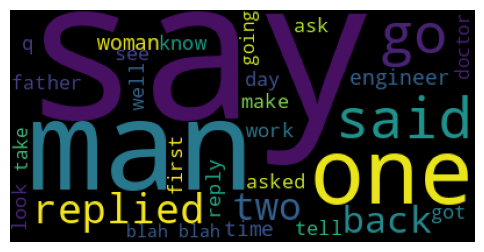

[('say', 82), ('man', 68), ('one', 62), ('go', 49), ('said', 44), ('engineer', 34), ('replied', 32), ('two', 29), ('back', 27), ('father', 26)]


In [89]:
create_wordcloud(jokes)
jokes_top_freq, jokes_top = get_top_words(jokes)
print(jokes_top_freq)

The wordcloud for the whole corpus show quite a few generic words. From it we can tell that the most jokes are retelling of someone (usually, a man) saying something or some kind of dialogue.

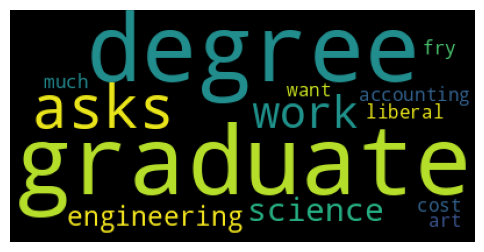

1
[('graduate', 4), ('degree', 4), ('asks', 4), ('work', 2), ('science', 1), ('engineering', 1), ('accounting', 1), ('much', 1), ('cost', 1), ('liberal', 1)]


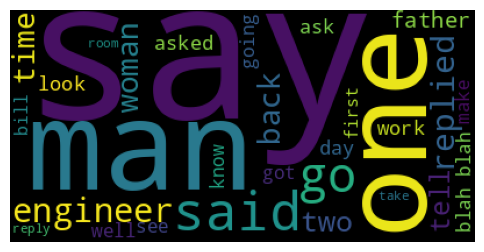

115
[('say', 66), ('man', 62), ('one', 54), ('said', 43), ('go', 41), ('engineer', 34), ('replied', 28), ('father', 26), ('back', 25), ('woman', 25)]


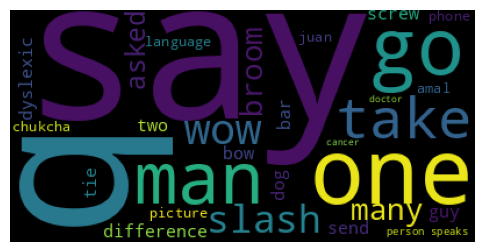

33
[('say', 10), ('q', 10), ('one', 8), ('go', 6), ('man', 5), ('take', 5), ('wow', 5), ('slash', 4), ('many', 4), ('person', 4)]

Most frequent only in all jokes corpus: {'two'}
Most frequent only in clusted corpuses {'many', 'slash', 'woman', 'accounting', 'asks', 'work', 'take', 'q', 'science', 'wow', 'much', 'engineering', 'graduate', 'cost', 'person', 'liberal', 'degree'}


In [100]:
print_cluster_top_and_wordclouds(kmeans_jokes)

As we can see, for k-means with raw ratings, clusters 1 and 2 have a lot of common top words considerting that cluster 2 doesn't have a lot of jokes and they seem to be short. They both seem to be about retelling a dialogue between people ('say', 'asked', 'said', 'speaks', etc.). One major difference that I notice is 'q' in cluster 2. We should take a closer look at what it means.

In [101]:
kmeans_jokes[2][:4]

['A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer\'s disease".  The man replies "Well,thank God I don\'t have cancer!"',
 'This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him.   "What could they possibly have said to make you move out?"   "They told me that you were a pedophile."   He replied, "That\'s an awfully big word for a ten year old."',
 "Q. What's 200 feet long and has 4 teeth?   A. The front row at a Willie Nelson Concert.",
 "Q. What's the difference between a man and a toilet?   A. A toilet doesn't follow you around after you use it."]

From this sample of jokes, we can guess that `q` is what is used in this dataset to represent a question. This shows that the jokes with questions have a similar pattern of how they are reviewed and they can be put together. The cluster 2 corrresponds to jokes with lower ratings, which might mean that such jokes tend to be worse, but the jokes with questions are not a majority in that cluster, so, it's difficult to tell.

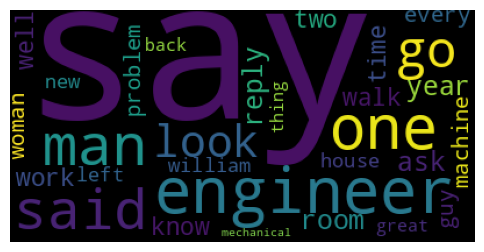

23
[('say', 23), ('engineer', 16), ('one', 15), ('man', 14), ('said', 13), ('go', 11), ('room', 11), ('asks', 10), ('get', 8), ('look', 8)]


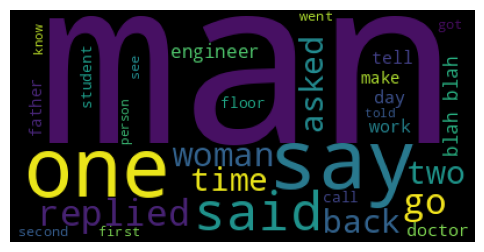

79
[('man', 44), ('say', 35), ('one', 34), ('said', 28), ('go', 25), ('replied', 20), ('blah', 20), ('father', 19), ('woman', 17), ('floor', 17)]


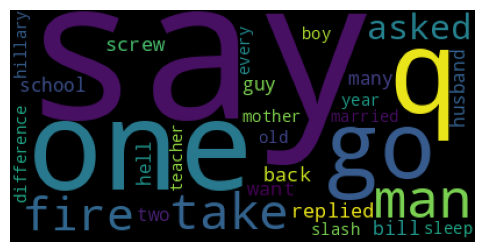

47
[('say', 18), ('one', 13), ('q', 11), ('go', 11), ('man', 9), ('take', 8), ('fire', 7), ('asked', 6), ('replied', 6), ('bill', 6)]

Most frequent only in all jokes corpus: {'back', 'two'}
Most frequent only in clusted corpuses {'bill', 'asked', 'fire', 'take', 'q', 'look', 'asks', 'get', 'blah', 'room', 'floor', 'woman'}


In [155]:
print_cluster_top_and_wordclouds(pca_kmeans_jokes)

For k-means after preprocessing with PCA, we can see that the clusters are once again do not deviate to far from the whole corpus's theme. They are about retelling a dialogue. However, compared to others there seems to be more diversity in what kind of words are at the top, but it's still difficult to tell what the clusters are about.

Another things to note, is that `q`s are once again separated into one cluster. And this cluster is the one with the lowest average rating. This is one more indication that jokes with questions might actually be worse.

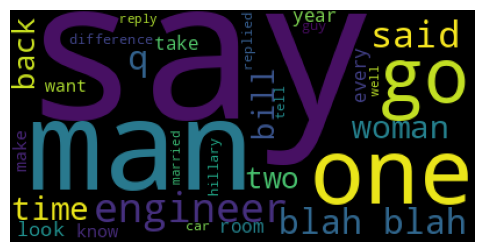

77
[('say', 52), ('man', 31), ('one', 31), ('go', 21), ('engineer', 21), ('blah', 20), ('said', 18), ('q', 16), ('get', 15), ('room', 15)]


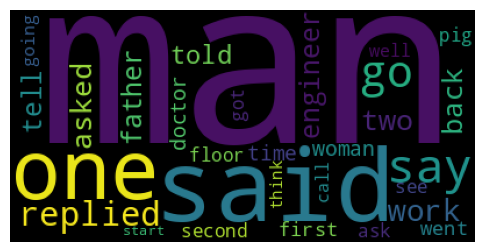

72
[('man', 36), ('one', 31), ('said', 26), ('go', 26), ('say', 24), ('replied', 20), ('father', 19), ('work', 16), ('asked', 15), ('two', 15)]

Most frequent only in all jokes corpus: {'back'}
Most frequent only in clusted corpuses {'blah', 'room', 'work', 'q', 'get', 'asked'}


In [93]:
print_cluster_top_and_wordclouds(nmf_kmeans_jokes_2)
# print_cluster_top_and_wordclouds(nmf_kmeans_jokes_6)

For k-means with NMF preprocessing, we can see that the word clouds confirm the previous observations. The clusters are very similar and they are also similar to the whole corpus. The most common words are connected with indirect speech or dialogue.

This shows that these clusters don't contain any useful information and that NMF preprocessing didn't help with the clusterization.

### Jokes Lengths

The last thing we are going to check if the clustering has any effect on the lengths of jokes. For this, we are going to plot the distribution of lengths of jokes in each cluster for the whole corpus and for each method separately.

<AxesSubplot: ylabel='Count'>

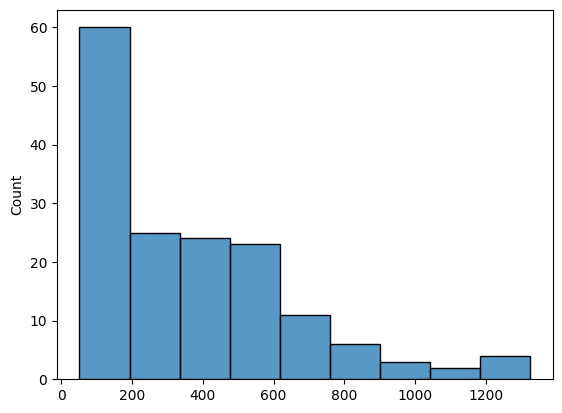

In [157]:
joke_lengths = [len(joke) for joke in jokes]
sns.histplot(joke_lengths)

The distribution of lengths of jokes in the whole corpus seems to skew towards being very small or medium lengths. There is also a long tail of very long jokes.

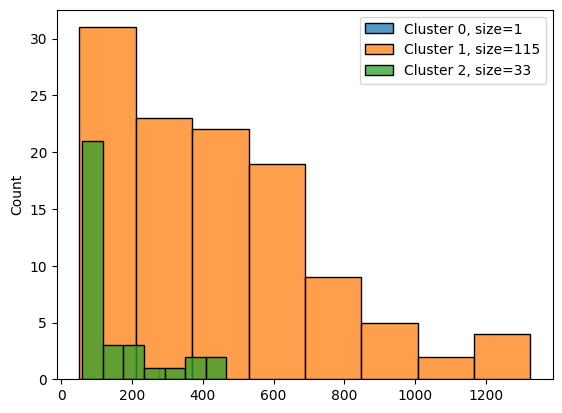

In [171]:
show_joke_lengths(kmeans_jokes)

For k-means clustering without preprocessing, we can see that there is a separate cluster for jokes that are not long. Cluster 2 contains basically all the other jokes and it has a similar distribution to the whole corpus without a spike for very short jokes.

This confirms the previous observation. The short and very short jokes are more likely to be worse and long jokes are more likely to be better.

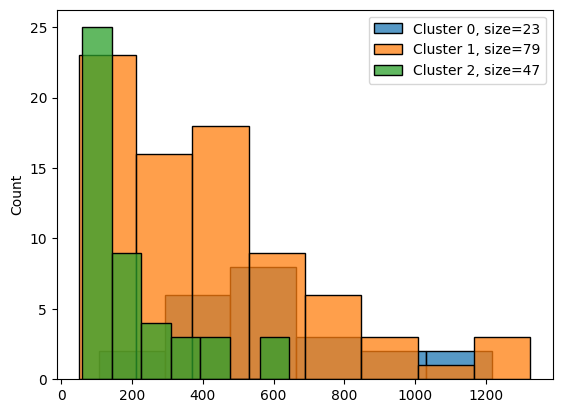

In [172]:
show_joke_lengths(pca_kmeans_jokes)

The clustering for k-means with PCA preprocessing also show the similar pattern, but it is more pronounced. Here cluster 0 contains only medium to long jokes and they are overwhelmingly reviewed as good. Cluster 1 contains the whole spread of jokes, which are considered a bit worse, but still good. Cluster 2 contains the short jokes, which are considered to be the worst.

This is an even more convincing observation that the length of the joke is a good indicator of the quality of the joke for very short or very long jokes.

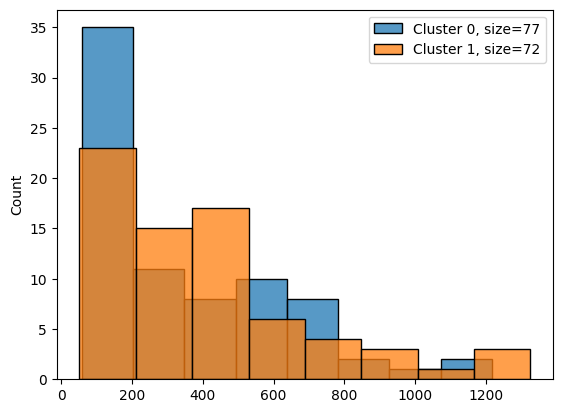

In [91]:
show_joke_lengths(nmf_kmeans_jokes_2)
# show_joke_lengths(nmf_kmeans_jokes_6)

As expected for NMF, we can see there is also not a big difference in the distribution of lengths of jokes in the clusters. This once again confirm that this method didn't produce good clusters.

# Discussions

In this project, we tried to find any trends or patterns that could help us identify the quality of a joke using ratings of jokes from a large number of reviwers. From the analysis, we can see that if there are any patterns between jokes and ratings, they are neither obvious nor straightforward.

The only major observation that we made is that the length of the joke can be a good indicator of the quality of the joke. This is especially true for very short or very long jokes. But it does not mean that making a joke longer will make it better. The result is likely comes from the fact that writing a long joke requires more effort and thus, it is more likely to be better.

The other observation that we made is that jokes with questions (or `q`s) are more likely to be rated worse. This is probably because those jokes do not flow as well as the other jokes because using direct questions in a joke can be a bit awkward.




|Method|Silhouette|Calinski-Harabasz|Davies-Bouldin|
|---|---|---|---|
|k-means without preprocessing|0.121|6.75|2.31|
|k-means with PCA preprocessing|0.237|14.93|2.50|
|k-means with NMF preprocessing|*0.918*|*178.86*|*0.36*|

Looking at the table of metrics for the chosen configurations of each method, we can see that it doesn't correlate with the results from the analysis of clusters. While the table shows that k-means with NMF preprocessing should be the best, the produced clusters definitely do not support that. This means that using these metrics to compare method with different preprocessing of data is not very useful. However, they are still helpful when comparing different configurations on the same data.

In order to extract further patterns from the data, several steps are possible. First, the analysis for the larger number of clusters can be done. This has the potential to reveal more patterns if the complexity of comparing a large number of small clusters can be overcome. Another thing to try is to use different methods for dealing with missing ratings. For example, these can include using the average rating for a joke or for a reviewer instead of a global average. Or, in the case of NMF, the missing ratings can be worked around by using a different loss function. The third thing to try is to use more methods for preprocessing the data or using different clustering methods. This can help to find a better way to represent the data and to find better clusters. Finally, the data used can be either more carefully selected or more data can be collected. In either case, this can help reduce the noise in the data and increase the signal of the patterns

# Contributions and takeaways

The project's goal was to experiment with different ways of clustering jokes based on their ratings and extacting patterns from the resulting clusters. For that, the Jesters dataset was used.

The data from different parts of the dataset were aggregated, which required correctly parsing how the jokes were stored for different parts of the dataset and confirming that jokes indices are consistent between different parts.

Doing EDA revealed several problems in the dataset. Firstly, some ratings had incorrect values, which needed to be put into the correct range. Secondly, there were some outliers: jokes and reviewers with very few ratings. Thirdly, while the number of missing ratings was not very high, it was still important to consider how to deal with them. The main issue was the last part of the dataset, which had a few new jokes and a small number of reviewers. This required mostly removing it from the dataset.

The modelling itself was done using k-means clustering. Three different methods of preprocessing the data were used: no preprocessing, PCA, and NMF. The results of the clustering were evaluated using several metrics. This showed that the best results were obtained with PCA, which increased the variance of the input data. However, the metrics between different methods didn't correlate with the results of the analysis.

Doing the more thourough analysis confirmed the hypothesis that the length of the joke can be a good indicator of the quality of the joke. No other useful and pronounced patterns were found. However, a further analysis of the data still has the potential to reveal more patterns.